Importación de archivos

In [234]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np


In [235]:
current_dir = os.getcwd()
print(current_dir)
nombre_archivo="yelp_academic_dataset_business.json"
nombre_archivo_rw="yelp_academic_dataset_review.json"

/Users/clarakearney/Documents/UdeSA/MIA/AprendizajeAutomaticoII/tp_yelp


In [236]:
path = os.path.join(current_dir, "yelp_dataset", nombre_archivo)
print(f"Leyendo archivo desde: {path}")

businesses = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        businesses.append(json.loads(line))

Leyendo archivo desde: /Users/clarakearney/Documents/UdeSA/MIA/AprendizajeAutomaticoII/tp_yelp/yelp_dataset/yelp_academic_dataset_business.json


Análisis inicial

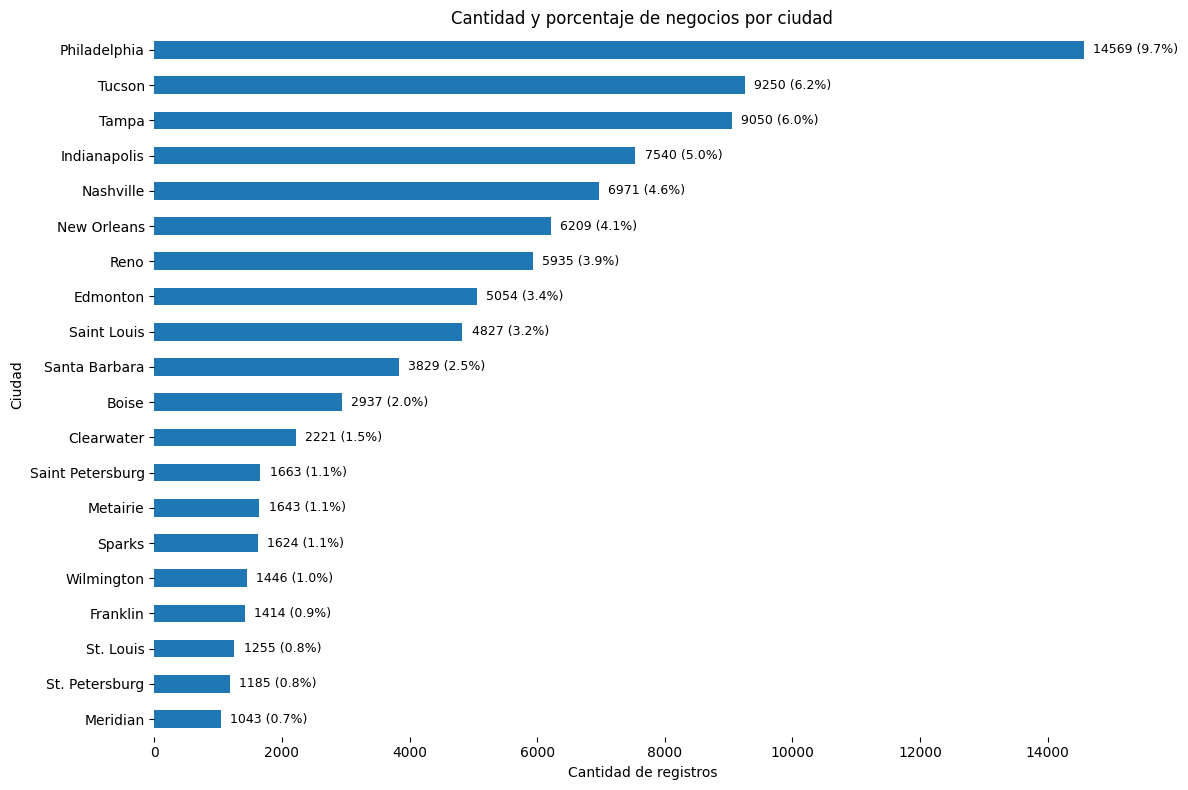

In [237]:
# Convertimos a DataFrame
df_business = pd.DataFrame(businesses)

# Contamos negocios por ciudad
city_counts = df_business["city"].value_counts()
total_businesses = city_counts.sum()

# Mostramos las 20 principales (por ejemplo)
top_cities = city_counts.head(20)
top_cities = top_cities.sort_values()
top_percentages = (top_cities / total_businesses) * 100

# Graficamos
plt.figure(figsize=(12, 8))
ax = top_cities.plot(kind="barh", color="#1f77b4")
plt.title("Cantidad y porcentaje de negocios por ciudad")
plt.xlabel("Cantidad de registros")
plt.ylabel("Ciudad")

# Etiquetamos cada barra con cantidad y porcentaje
label_offset = max(top_cities) * 0.01
for idx, value in enumerate(top_cities.values):
    pct = top_percentages.iloc[idx]
    ax.text(value + label_offset, idx, f"{value:.0f} ({pct:.1f}%)", va="center", fontsize=9)

# Quitamos el recuadro del gráfico
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

/var/folders/n9/dtbl7mzs0dl8wwd0h1sv_3z80000gn/T/ipykernel_12819/82109729.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', city_star_counts.shape[1])


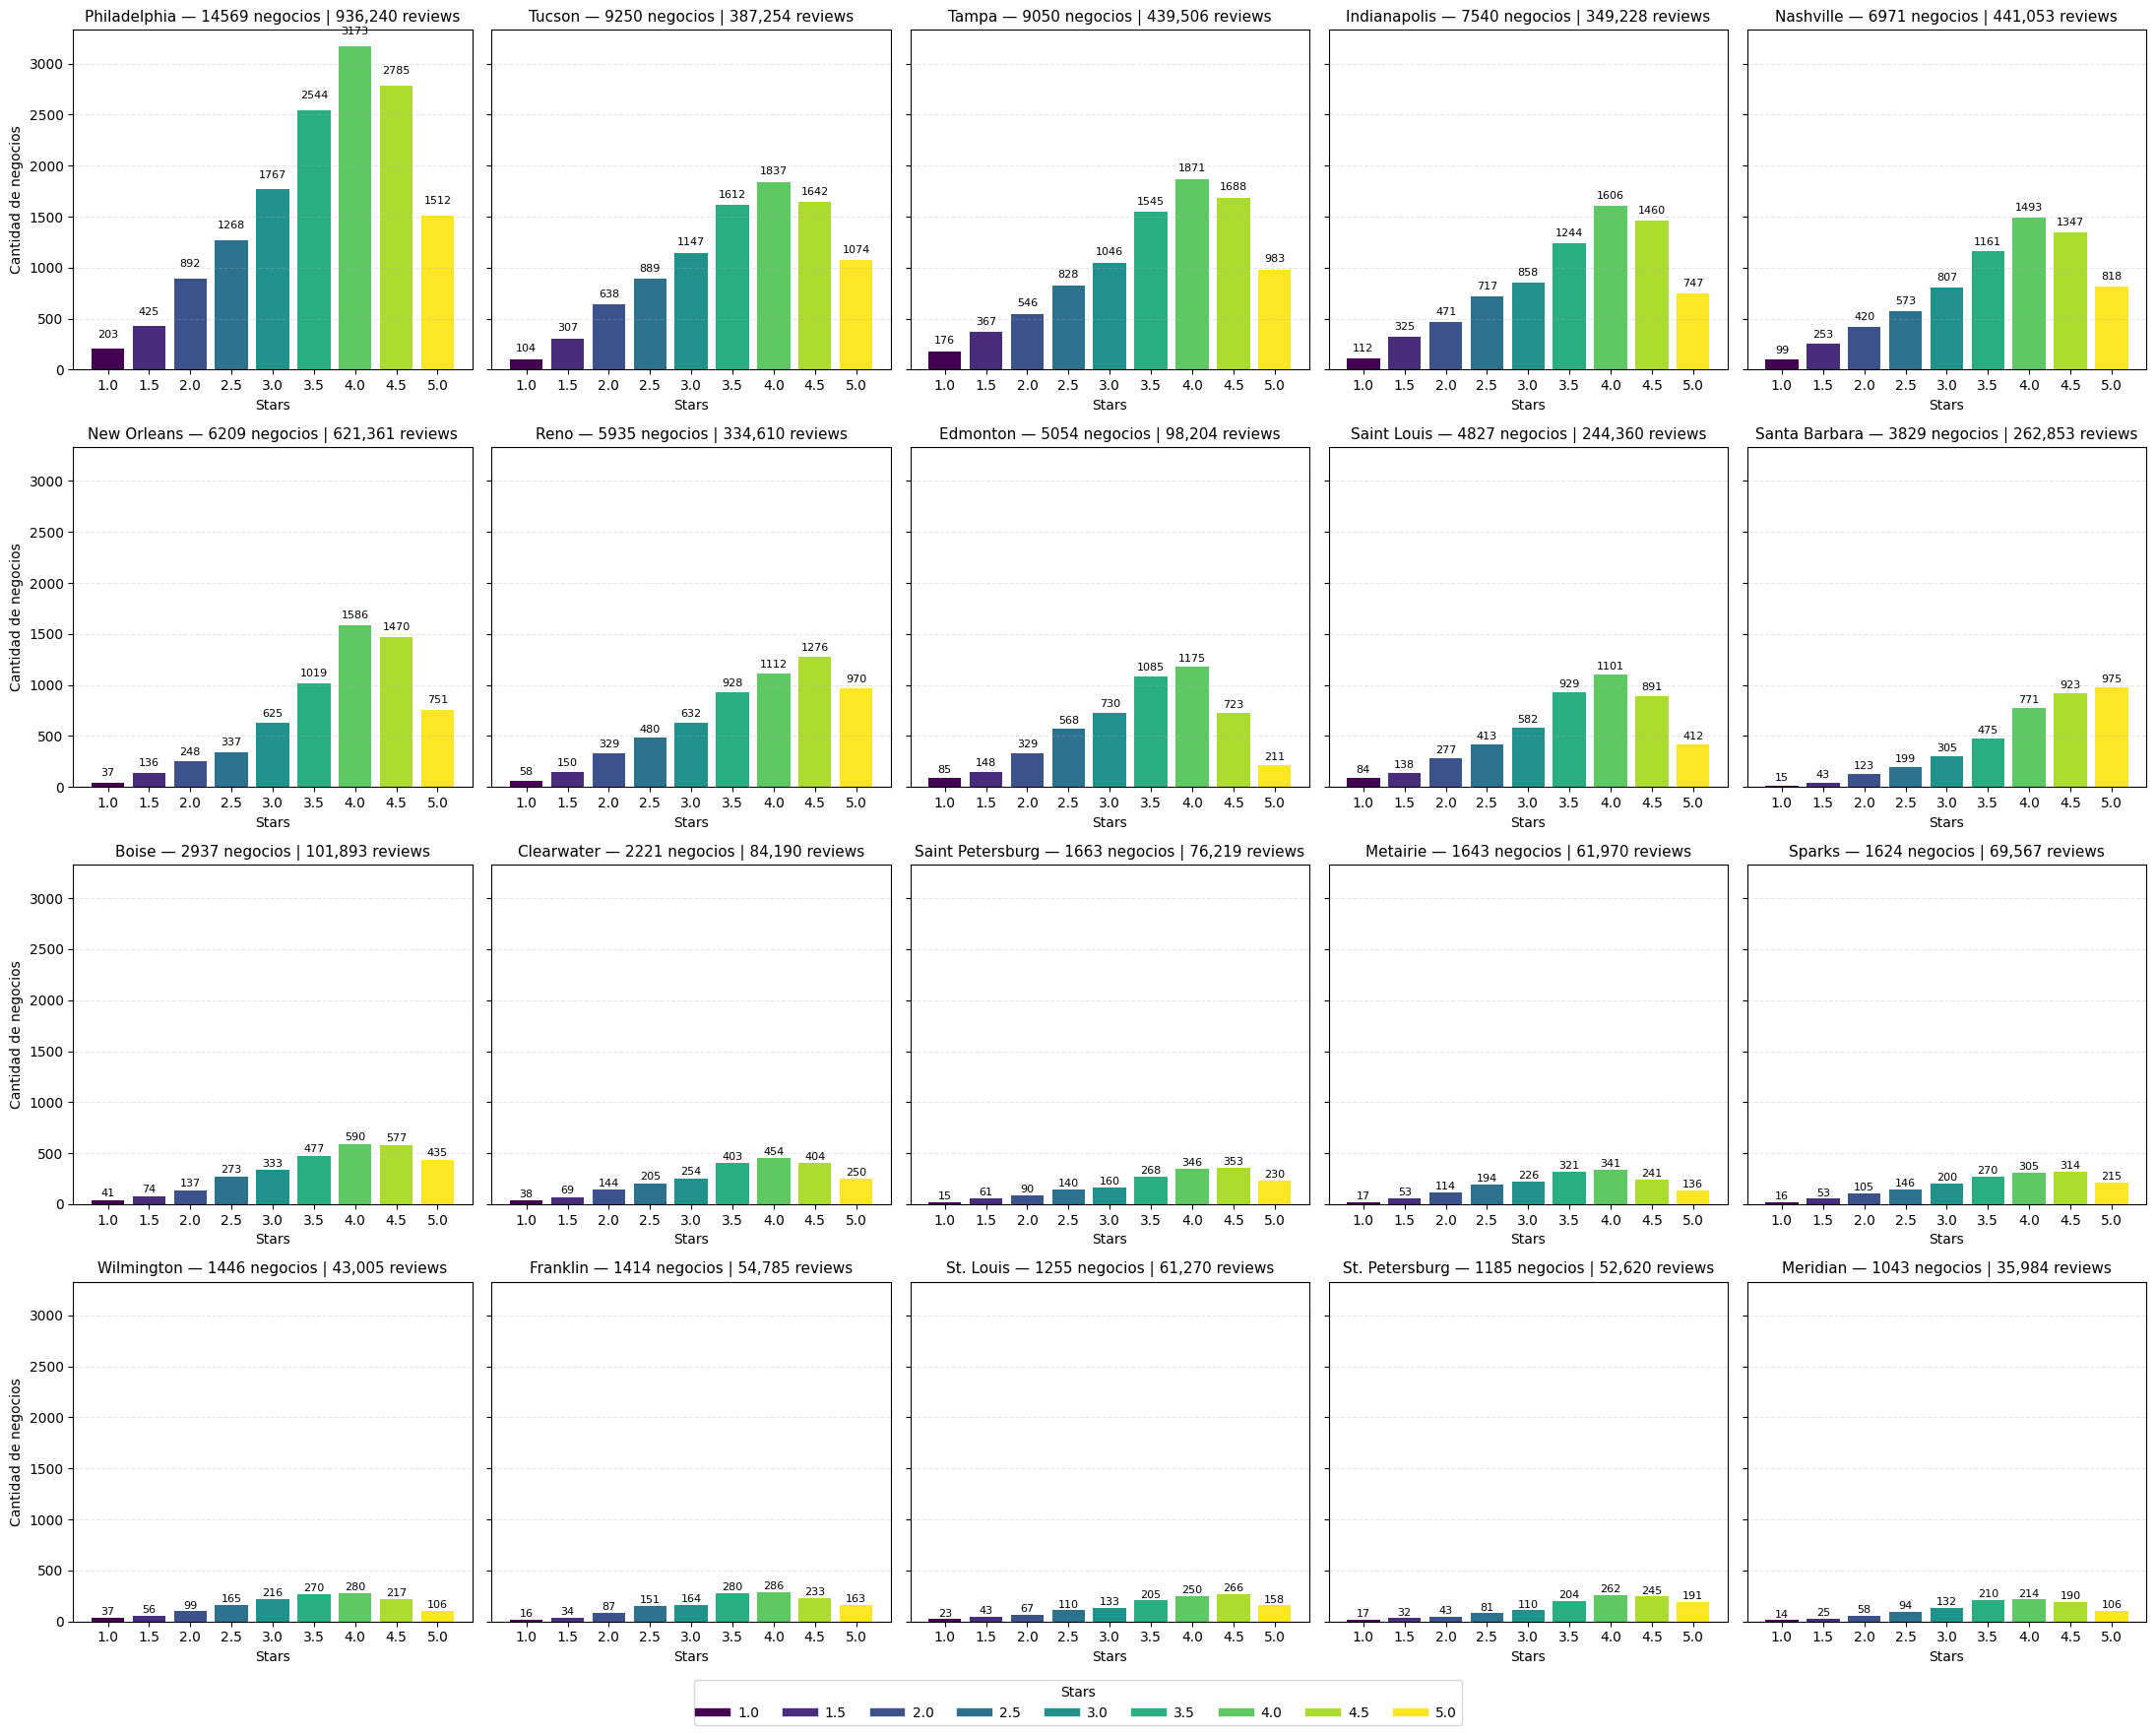

In [238]:
# Negocios por ciudad: top 20 ciudades desagregadas por estrellas
top_n = 20
city_counts = df_business['city'].value_counts()
top_cities = city_counts.head(top_n).index

subset = df_business[df_business['city'].isin(top_cities)]
city_star_counts = subset.groupby(['city', 'stars']).size().unstack(fill_value=0)
city_star_counts = city_star_counts.reindex(columns=sorted(city_star_counts.columns))
city_star_counts = city_star_counts.reindex(top_cities)

city_review_counts = subset.groupby('city')['review_count'].sum().reindex(top_cities).fillna(0)
city_totals = city_star_counts.sum(axis=1)

rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(22, 18), sharey=True)
axes = axes.flatten()
cmap = plt.cm.get_cmap('viridis', city_star_counts.shape[1])
star_labels = [str(s) for s in city_star_counts.columns]

for idx, city in enumerate(top_cities):
    ax = axes[idx]
    counts = city_star_counts.loc[city]
    colors = [cmap(i) for i in range(len(counts))]
    bars = ax.bar(star_labels, counts.values, color=colors)

    total_reviews = city_review_counts.loc[city]
    total_businesses = city_totals.loc[city]
    ax.set_title(f'{city} — {total_businesses:.0f} negocios | {total_reviews:,.0f} reviews', fontsize=11)
    ax.set_xlabel('Stars')
    if idx % cols == 0:
        ax.set_ylabel('Cantidad de negocios')

    max_height = counts.max() or 1
    for bar, value in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, value + max_height * 0.03, f'{value:.0f}', ha='center', va='bottom', fontsize=8)

    ax.grid(axis='y', linestyle='--', alpha=0.3)

for ax in axes[len(top_cities):]:
    ax.axis('off')

handles = [plt.Line2D([0], [0], color=cmap(i), lw=6) for i in range(len(star_labels))]
fig.legend(handles, star_labels, title='Stars', loc='lower center', ncol=len(star_labels), bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


/var/folders/n9/dtbl7mzs0dl8wwd0h1sv_3z80000gn/T/ipykernel_12819/761979711.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  state_cmap = plt.cm.get_cmap('plasma', state_star_counts.shape[1])


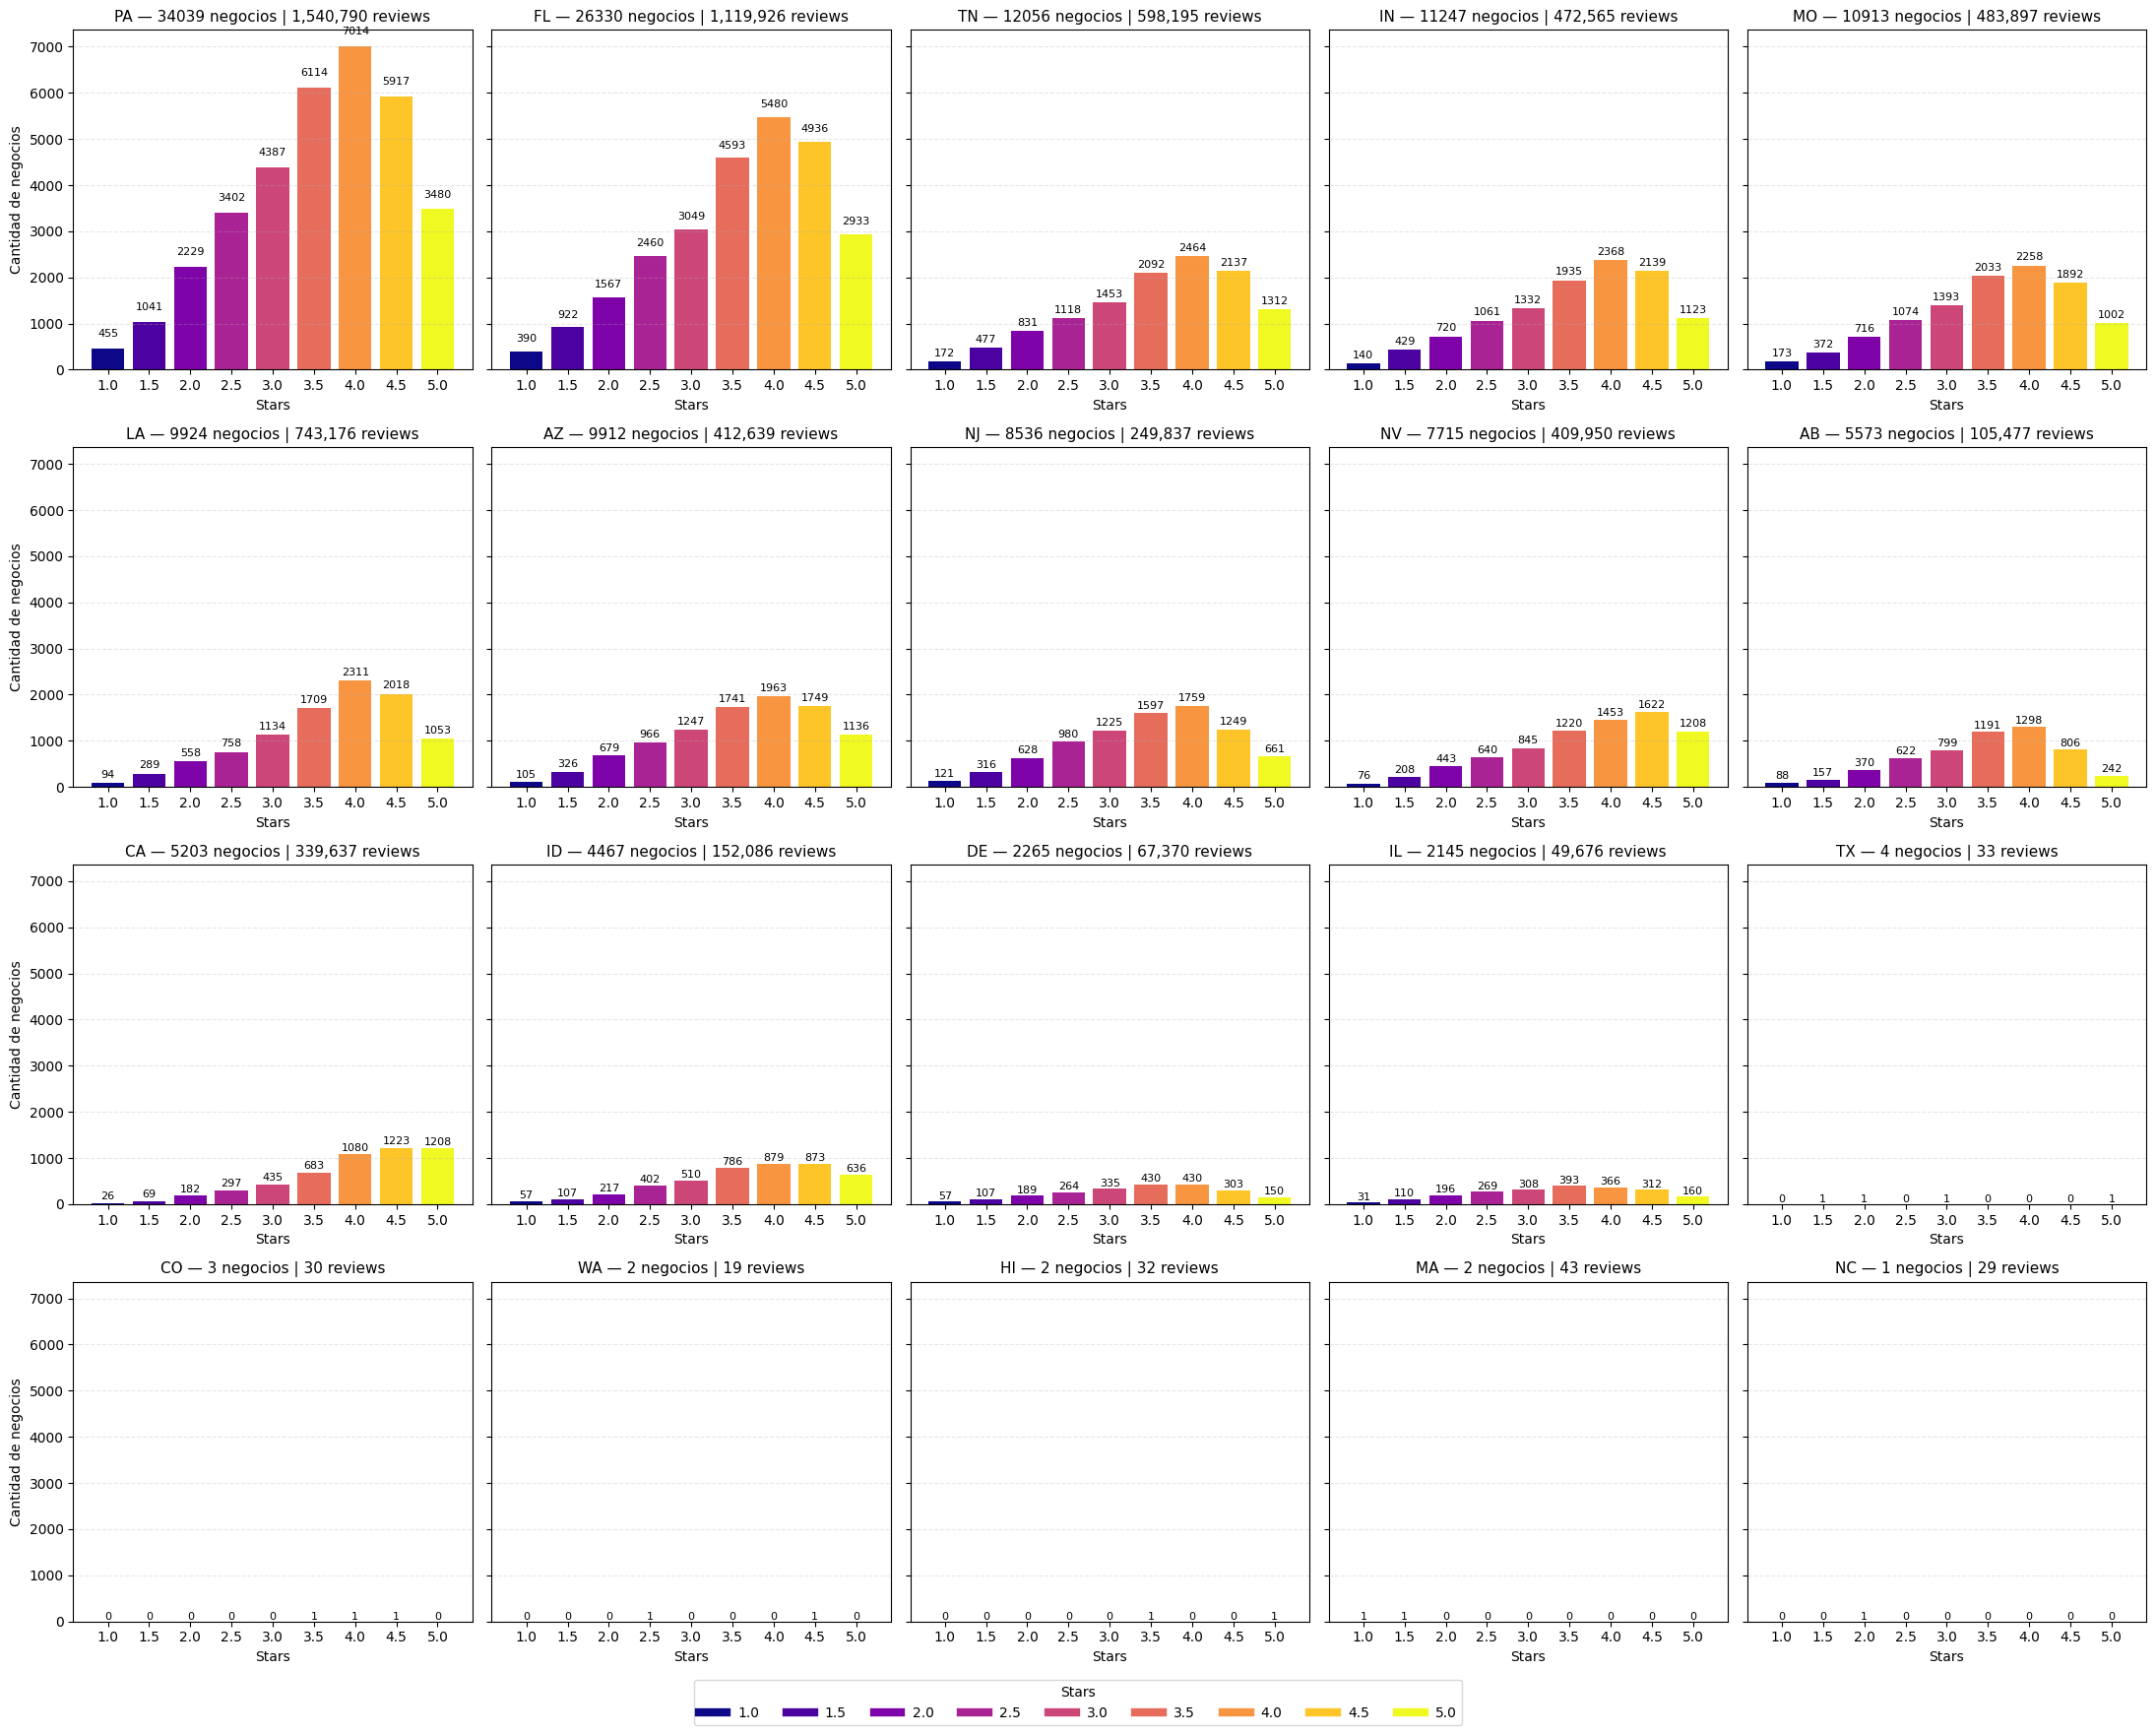

In [239]:
# Negocios por estado: top 20 estados desagregados por estrellas
top_states = 20
state_counts = df_business['state'].value_counts()
top_state_names = state_counts.head(top_states).index

state_subset = df_business[df_business['state'].isin(top_state_names)]
state_star_counts = state_subset.groupby(['state', 'stars']).size().unstack(fill_value=0)
state_star_counts = state_star_counts.reindex(columns=sorted(state_star_counts.columns))
state_star_counts = state_star_counts.reindex(top_state_names)

state_review_counts = state_subset.groupby('state')['review_count'].sum().reindex(top_state_names).fillna(0)
state_totals = state_star_counts.sum(axis=1)

rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(22, 18), sharey=True)
axes = axes.flatten()
state_cmap = plt.cm.get_cmap('plasma', state_star_counts.shape[1])
state_star_labels = [str(s) for s in state_star_counts.columns]

for idx, state in enumerate(top_state_names):
    ax = axes[idx]
    counts = state_star_counts.loc[state]
    colors = [state_cmap(i) for i in range(len(counts))]
    bars = ax.bar(state_star_labels, counts.values, color=colors)

    total_reviews = state_review_counts.loc[state]
    total_businesses = state_totals.loc[state]
    ax.set_title(f'{state} — {total_businesses:.0f} negocios | {total_reviews:,.0f} reviews', fontsize=11)
    ax.set_xlabel('Stars')
    if idx % cols == 0:
        ax.set_ylabel('Cantidad de negocios')

    max_height = counts.max() or 1
    for bar, value in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, value + max_height * 0.03, f'{value:.0f}', ha='center', va='bottom', fontsize=8)

    ax.grid(axis='y', linestyle='--', alpha=0.3)

for ax in axes[len(top_state_names):]:
    ax.axis('off')

state_handles = [plt.Line2D([0], [0], color=state_cmap(i), lw=6) for i in range(len(state_star_labels))]
fig.legend(state_handles, state_star_labels, title='Stars', loc='lower center', ncol=len(state_star_labels), bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [240]:
# Limpieza y vectorización de categorías
df_business['categories'] = df_business['categories'].fillna('')
df_business['categories_list'] = df_business['categories'].apply(
    lambda x: [c.strip() for c in x.split(',') if c.strip() != '']
)

mlb = MultiLabelBinarizer()
mlb.fit(df_business['categories_list'])
category_vectors = mlb.transform(df_business['categories_list'])
df_business['category_vector'] = list(category_vectors)
print(f"Total de categorías únicas: {len(mlb.classes_):,}")


Total de categorías únicas: 1,311


Negocios con categorías: 150,346
Categorías únicas identificadas: 1,311
count    150346.000000
mean          4.447022
std           2.233734
min           0.000000
50%           4.000000
90%           7.000000
99%          11.000000
max          36.000000
Name: categories, dtype: float64


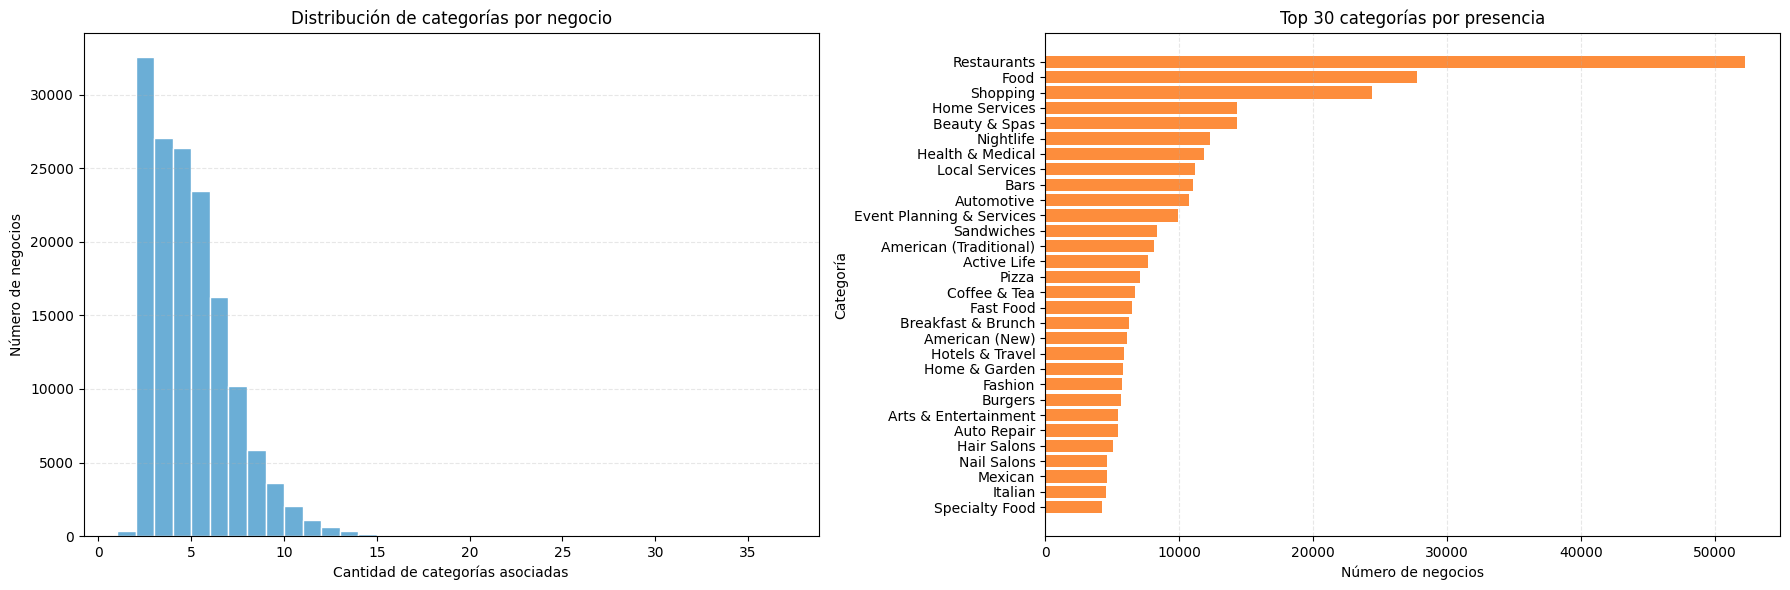

In [241]:
# Exploración previa de categorías
category_series = df_business['categories'].dropna()
category_lists = category_series.str.split(',').apply(lambda lst: [c.strip() for c in lst if c and c.strip()])

per_business_category_counts = category_lists.apply(len)
unique_categories = sorted({cat for cats in category_lists for cat in cats})
num_unique_categories = len(unique_categories)
print(f"Negocios con categorías: {len(category_lists):,}")
print(f"Categorías únicas identificadas: {num_unique_categories:,}")
print(per_business_category_counts.describe(percentiles=[0.5, 0.9, 0.99]))

category_freq = pd.Series([cat for cats in category_lists for cat in cats]).value_counts()
top_categories = category_freq.head(30)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].hist(per_business_category_counts, bins=range(1, per_business_category_counts.max() + 2), color='#6baed6', edgecolor='white')
axes[0].set_title('Distribución de categorías por negocio')
axes[0].set_xlabel('Cantidad de categorías asociadas')
axes[0].set_ylabel('Número de negocios')
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

axes[1].barh(top_categories.index[::-1], top_categories.values[::-1], color='#fd8d3c')
axes[1].set_title('Top 30 categorías por presencia')
axes[1].set_xlabel('Número de negocios')
axes[1].set_ylabel('Categoría')
axes[1].grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [242]:
# Listado completo de categorías únicas
if 'category_lists' not in globals():
    category_series = df_business['categories'].dropna()
    category_lists = category_series.str.split(',').apply(lambda lst: [c.strip() for c in lst if c and c.strip()])

category_freq_full = pd.Series([cat for cats in category_lists for cat in cats]).value_counts()
category_catalog = (
    category_freq_full
    .sort_index()
    .rename_axis('category')
    .reset_index(name='num_negocios_asociados')
)
display(category_catalog)
print(f'Categorías totales: {len(category_catalog):,}')
print('Podés filtrar con expresiones regulares, por ejemplo:')
display(category_catalog[category_catalog['category'].str.contains('Restaurant', case=False)])


category  num_negocios_asociados
0            & Probates                      38
1           3D Printing                       5
2     ATV Rentals/Tours                      12
3            Acai Bowls                     268
4           Accessories                    1639
...                 ...                     ...
1306              Wraps                     310
1307        Yelp Events                      48
1308               Yoga                     938
1309          Ziplining                      12
1310               Zoos                      52

[1311 rows x 2 columns]

Categorías totales: 1,311
Podés filtrar con expresiones regulares, por ejemplo:


category  num_negocios_asociados
937    Pop-Up Restaurants                      75
1013  Restaurant Supplies                      25
1014          Restaurants                   52268

category  total_reviews  num_businesses  avg_stars
1014                Restaurants        4561279           52268   3.515172
466                        Food        1752281           27781   3.668982
806                   Nightlife        1488163           12281   3.655525
104                        Bars        1406415           11065   3.648848
33       American (Traditional)         976483            8139   3.399742
32               American (New)         950560            6097   3.590782
165          Breakfast & Brunch         839467            6239   3.569562
1033                 Sandwiches         669139            8366   3.544227
1045                    Seafood         600183            3539   3.674908
419   Event Planning & Services         591442            9895   3.693633
1069                   Shopping         505372           24395   3.620988
920                       Pizza         456944            7093   3.353306
176                     Burgers         429866            5636   2.934972
262                Coffee & Tea         428230            6703   3.517679
647                     Italian         422530            4573   3.510059
752                     Mexican         416307            4600   3.515109
115               Beauty & Spas         354203           14292   3.810558
66         Arts & Entertainment         335139            5434   3.979941
261               Cocktail Bars         328110            1718   3.897555
1030                      Salad         321566            3064   3.653394
607             Hotels & Travel         320906            5857   3.254909
340                    Desserts         297082            3186   3.978343
190                       Cafes         280552            2756   3.956821
1109             Specialty Food         259189            4233   3.975077
192                Cajun/Creole         246263             923   3.716143
1128                Steakhouses         231159            1506   3.395418
85                   Automotive         227706           10773   3.506869
583               Home Services         226962           14356   3.456778
117                        Beer         225027            2413   3.798798
1298             Wine & Spirits         225027            2413   3.798798

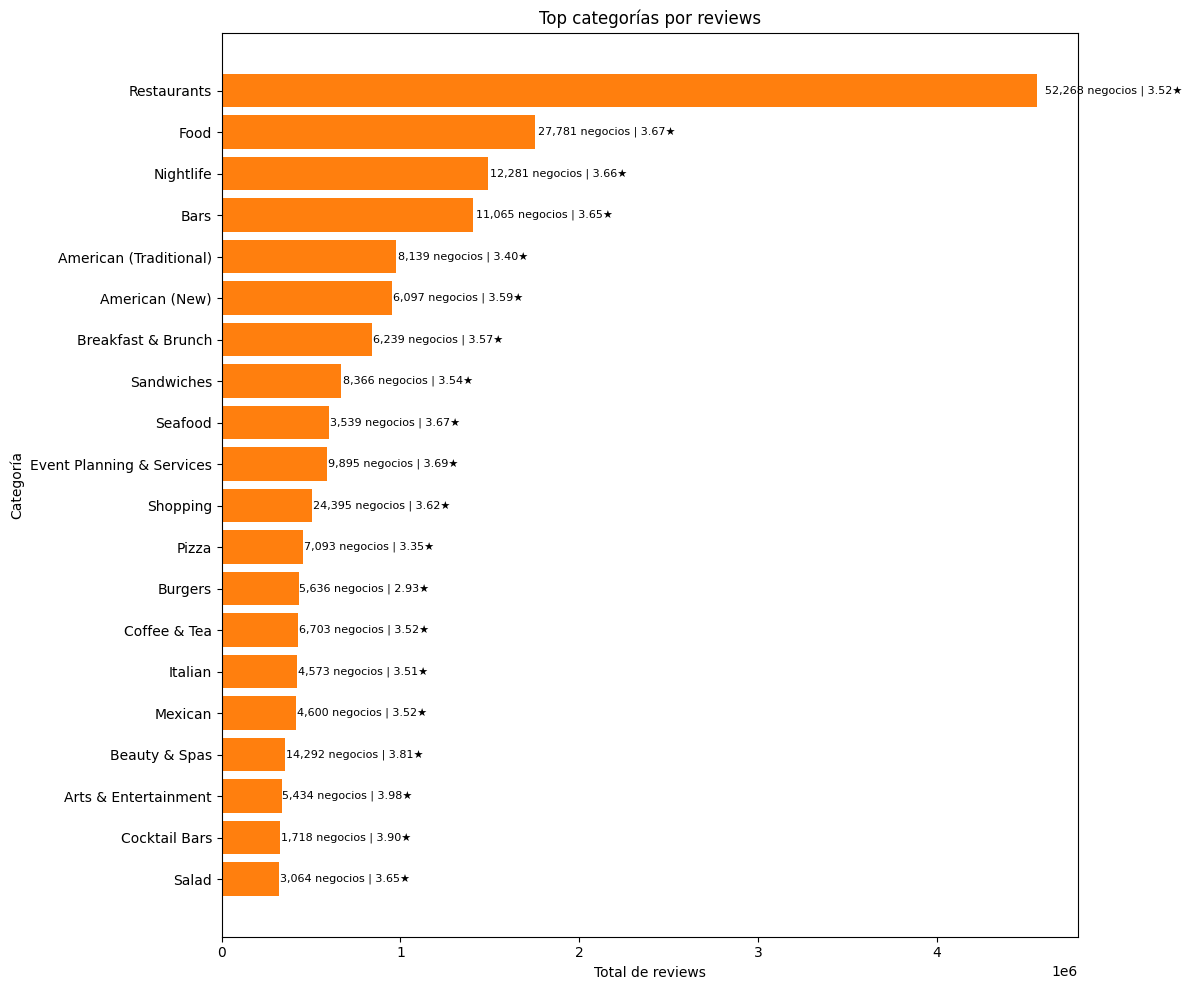

In [243]:
# Recuento de reviews, negocios y reputación por categoría usando category_vectors
if 'category_vector' not in df_business.columns:
    raise ValueError('category_vector no está disponible. Ejecutá la celda de vectorización primero.')

category_matrix = np.vstack(df_business['category_vector'].values)
review_counts = category_matrix.T.dot(df_business['review_count'].values)
business_counts = category_matrix.sum(axis=0)
star_sums = category_matrix.T.dot(df_business['stars'].values)
avg_stars = np.divide(star_sums, business_counts, out=np.zeros_like(star_sums), where=business_counts!=0)

category_summary_df = pd.DataFrame({
    'category': mlb.classes_,
    'total_reviews': review_counts,
    'num_businesses': business_counts,
    'avg_stars': avg_stars
}).sort_values('total_reviews', ascending=False)

display(category_summary_df.head(30))
plt.figure(figsize=(12, 10))
top_summary = category_summary_df.head(20).sort_values('total_reviews')
bars = plt.barh(top_summary['category'], top_summary['total_reviews'], color='#ff7f0e')
plt.title('Top categorías por reviews')
plt.xlabel('Total de reviews')
plt.ylabel('Categoría')
for idx, row in enumerate(top_summary.itertuples()):
    label = f"{row.num_businesses:,.0f} negocios | {row.avg_stars:.2f}★"
    plt.text(row.total_reviews * 1.01, idx, label, va='center', fontsize=8)
plt.tight_layout()
plt.show()


num_businesses  total_reviews  avg_stars
category                                                           
Restaurants                         52268        4561279   3.515172
Food                                27781        1752281   3.668982
Shopping                            24395         505372   3.620988
Home Services                       14356         226962   3.456778
Beauty & Spas                       14292         354203   3.810558
Nightlife                           12281        1488163   3.655525
Health & Medical                    11890         188041   3.631665
Local Services                      11198         198995   3.615378
Bars                                11065        1406415   3.648848
Automotive                          10773         227706   3.506869
Event Planning & Services            9895         591442   3.693633
Sandwiches                           8366         669139   3.544227
American (Traditional)               8139         976483   3.399742
Active Life                          7687         200921   4.005139
Pizza                                7093         456944   3.353306
Coffee & Tea                         6703         428230   3.517679
Fast Food                            6472         224529   2.632185
Breakfast & Brunch                   6239         839467   3.569562
American (New)                       6097         950560   3.590782
Hotels & Travel                      5857         320906   3.254909

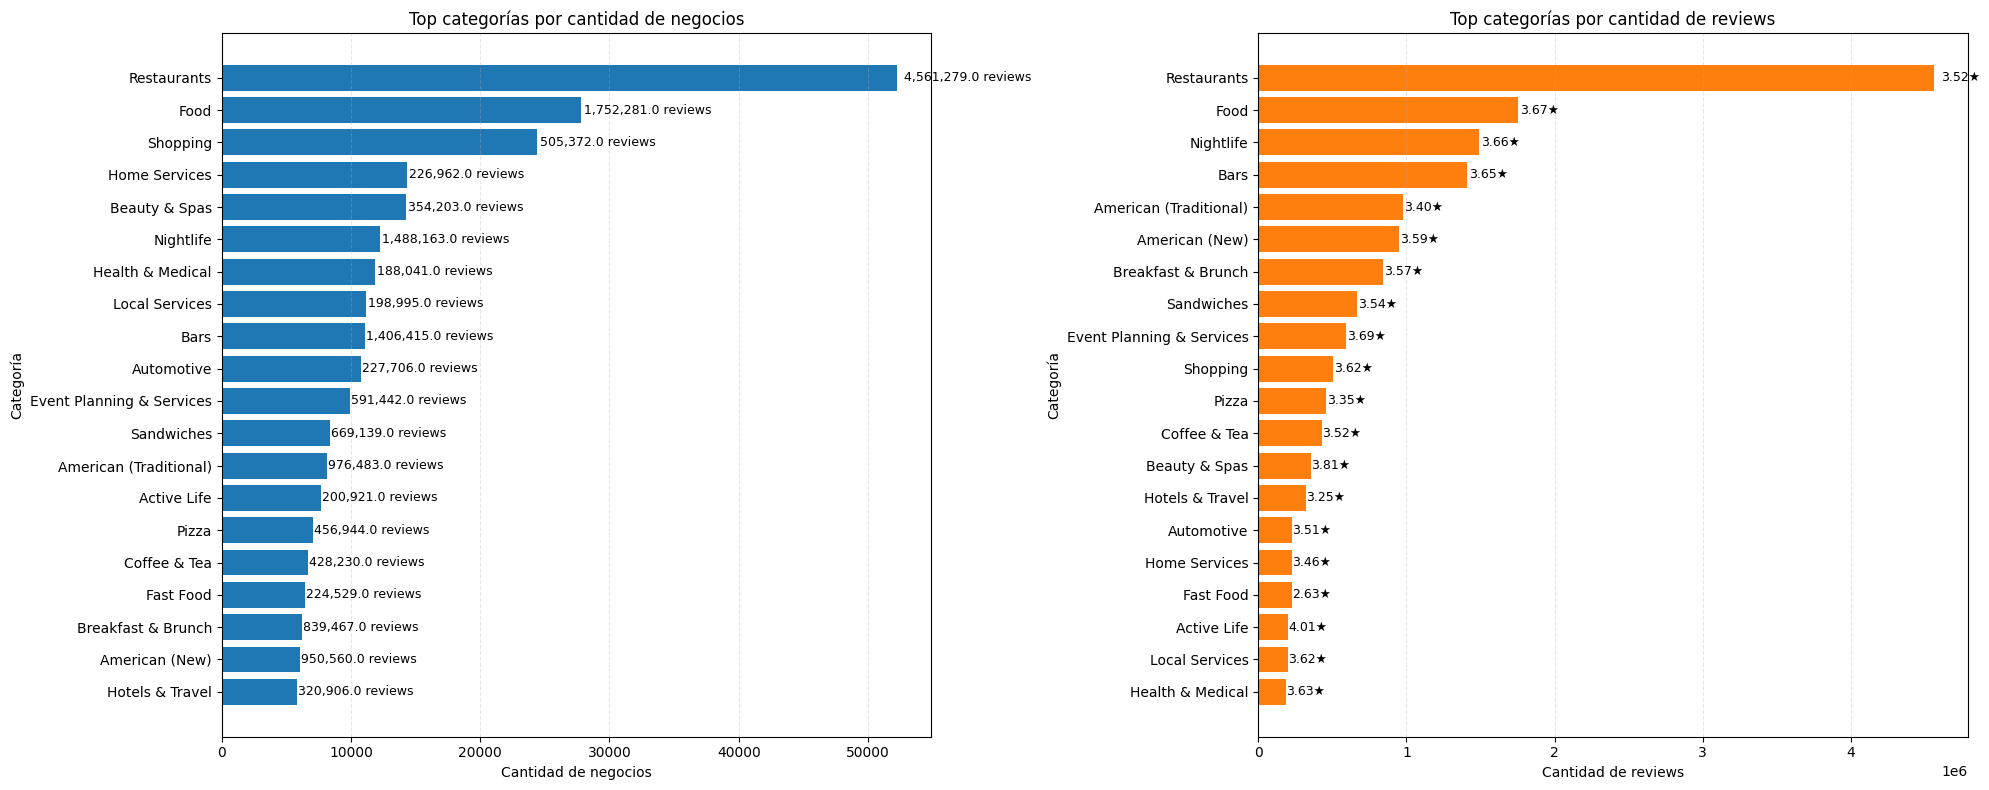

In [244]:
# Análisis de categorías: volumen, reviews y reputación
# sample_size = 30000
category_cols = ['categories', 'stars', 'review_count']
category_df = df_business[category_cols].dropna(subset=['categories'])
# if len(category_df) > sample_size:
#     category_df = category_df.sample(sample_size, random_state=42)

category_long = (
    category_df.assign(category=category_df['categories'].str.split(','))
    .explode('category')
)
category_long['category'] = category_long['category'].str.strip()
category_long = category_long[category_long['category'].notna() & (category_long['category'] != '')]

category_stats = (
    category_long.groupby('category')
    .agg(
        num_businesses=('category', 'size'),
        total_reviews=('review_count', 'sum'),
        avg_stars=('stars', 'mean')
    )
    .sort_values('num_businesses', ascending=False)
)

top_n = 20
top_categories = category_stats.head(top_n)
display(top_categories)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
count_order = top_categories.sort_values('num_businesses')
axes[0].barh(count_order.index, count_order['num_businesses'], color='#1f77b4')
axes[0].set_title('Top categorías por cantidad de negocios')
axes[0].set_xlabel('Cantidad de negocios')
axes[0].set_ylabel('Categoría')
for idx, (cat, row) in enumerate(count_order.iterrows()):
    axes[0].text(row['num_businesses'] * 1.01, idx, f"{row['total_reviews']:,} reviews", va='center', fontsize=9)

review_order = top_categories.sort_values('total_reviews')
axes[1].barh(review_order.index, review_order['total_reviews'], color='#ff7f0e')
axes[1].set_title('Top categorías por cantidad de reviews')
axes[1].set_xlabel('Cantidad de reviews')
axes[1].set_ylabel('Categoría')
for idx, (cat, row) in enumerate(review_order.iterrows()):
    axes[1].text(row['total_reviews'] * 1.01, idx, f"{row['avg_stars']:.2f}★", va='center', fontsize=9)

for ax in axes:
    ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [245]:
df_business

business_id                      name  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2       tUFrWirKiKi_TAnsVWINQQ                    Target   
3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
...                        ...                       ...   
150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails   
150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited   
150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   

                                address           city state postal_code  \
0                1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1       87 Grasso Plaza Shopping Center         Affton    MO       63123   
2                  5255 E Broadway Blvd         Tucson    AZ       85711   
3                           935 Race St   Philadelphia    PA       19107   
4                         101 Walnut St     Green Lane    PA       18054   
...                                 ...            ...   ...         ...   
150341                3388 Gateway Blvd       Edmonton    AB     T6J 5H2   
150342               2813 Bransford Ave      Nashville    TN       37204   
150343           6020 E 82nd St, Ste 46   Indianapolis    IN       46250   
150344                     2472 Troy Rd   Edwardsville    IL       62025   
150345            238 Apollo Beach Blvd   Apollo beach    FL       33572   

         latitude   longitude  stars  review_count  is_open  \
0       34.426679 -119.711197    5.0             7        0   
1       38.551126  -90.335695    3.0            15        1   
2       32.223236 -110.880452    3.5            22        0   
3       39.955505  -75.155564    4.0            80        1   
4       40.338183  -75.471659    4.5            13        1   
...           ...         ...    ...           ...      ...   
150341  53.468419 -113.492054    3.0            13        1   
150342  36.115118  -86.766925    4.0             5        1   
150343  39.908707  -86.065088    3.5             8        1   
150344  38.782351  -89.950558    4.0            24        1   
150345  27.771002  -82.394910    4.5             9        1   

                                               attributes  \
0                           {'ByAppointmentOnly': 'True'}   
1                  {'BusinessAcceptsCreditCards': 'True'}   
2       {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3       {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4       {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   
...                                                   ...   
150341  {'ByAppointmentOnly': 'False', 'RestaurantsPri...   
150342  {'BusinessAcceptsCreditCards': 'True', 'Restau...   
150343  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
150344  {'BusinessParking': '{'garage': False, 'street...   
150345  {'WheelchairAccessible': 'True', 'BusinessAcce...   

                                               categories  \
0       Doctors, Traditional Chinese Medicine, Naturop...   
1       Shipping Centers, Local Services, Notaries, Ma...   
2       Department Stores, Shopping, Fashion, Home & G...   
3       Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                               Brewpubs, Breweries, Food   
...                                                   ...   
150341                         Nail Salons, Beauty & Spas   
150342  Pets, Nurseries & Gardening, Pet Stores, Hobby...   
150343  Shopping, Jewelry, Piercing, Toy Stores, Beaut...   
150344  Fitness/Exercise Equipment, Eyewear & Optician...   
150345  Beauty & Spas, Permanent Makeup, Piercing, Tattoo   

                                                    hours  \
0                                                    None   
1       {'Monday': '0:0-0:0', 'Tuesday':

num_businesses  total_reviews  avg_stars
category                                                     
Restaurants                   52268        4561279   3.515172
Pop-Up Restaurants               75           4048   4.193333
Restaurant Supplies              25            637   3.780000

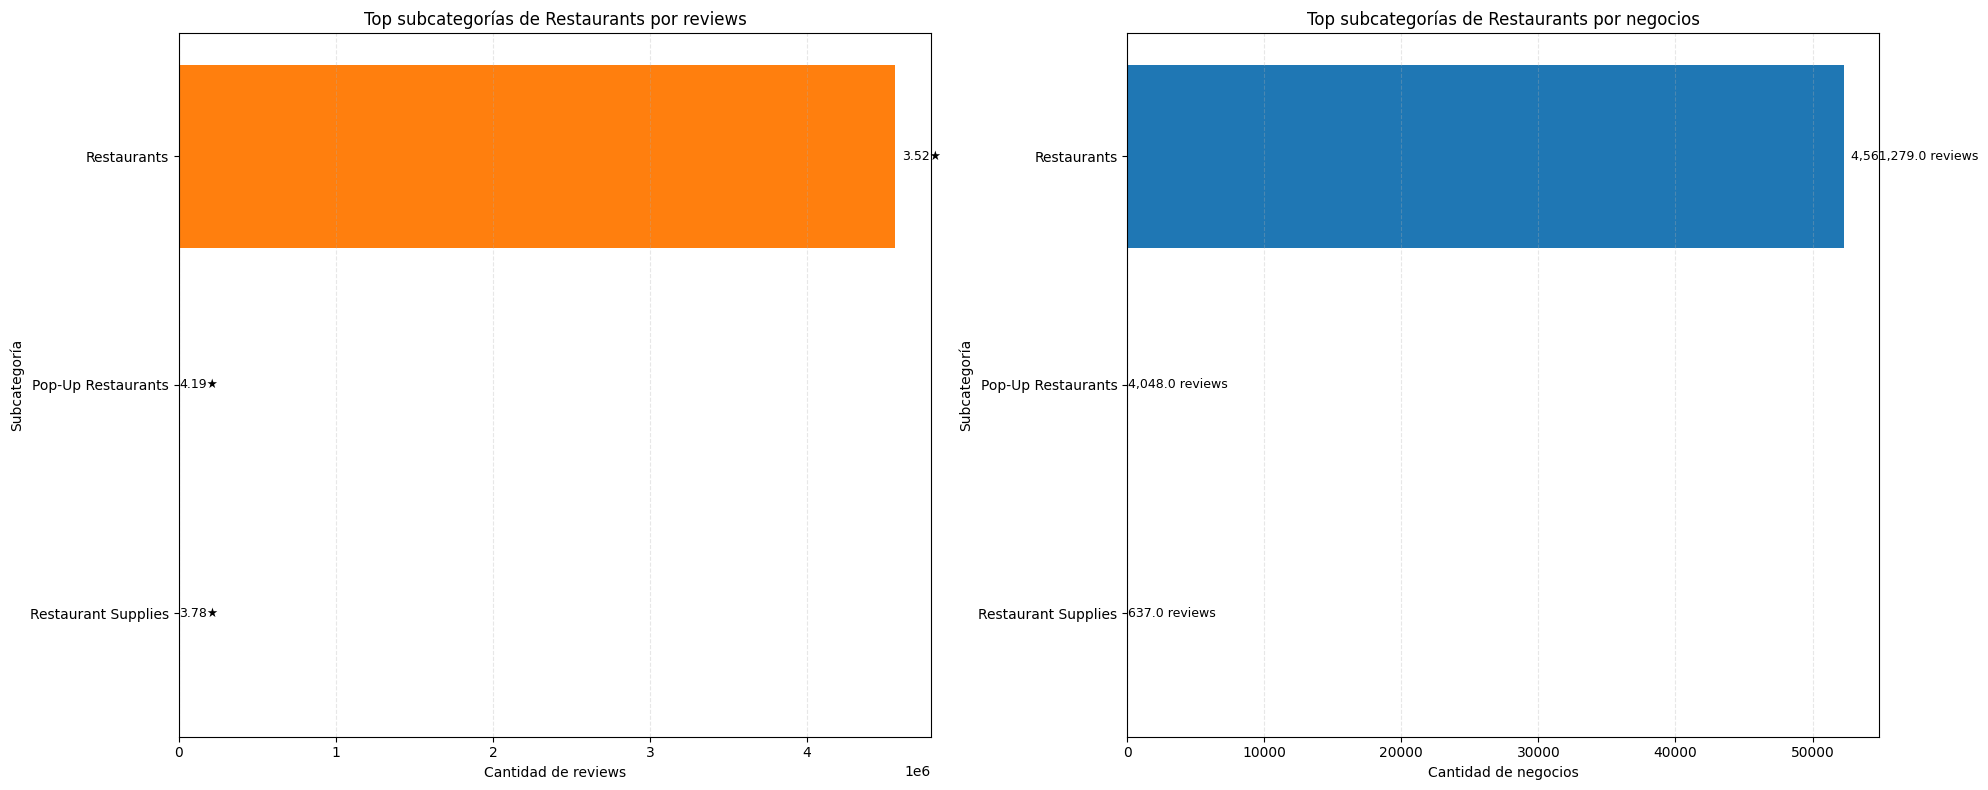

In [246]:
# Subcategorías dentro de Restaurants
category_series = df_business['categories'].fillna('')
restaurant_mask = category_series.str.contains('Restaurant', case=False)
restaurant_df = df_business.loc[restaurant_mask, ['categories', 'stars', 'review_count']].copy()
restaurant_df = restaurant_df[restaurant_df['categories'].notna()]
restaurant_long = (
    restaurant_df.assign(category=restaurant_df['categories'].str.split(','))
    .explode('category')
)
restaurant_long['category'] = restaurant_long['category'].str.strip()
restaurant_long = restaurant_long[restaurant_long['category'].str.contains('Restaurant', case=False, na=False)]

restaurant_stats = (
    restaurant_long.groupby('category')
    .agg(
        num_businesses=('category', 'size'),
        total_reviews=('review_count', 'sum'),
        avg_stars=('stars', 'mean')
    )
    .sort_values('total_reviews', ascending=False)
)
top_subcats = restaurant_stats.head(20)
display(top_subcats)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
review_order = top_subcats.sort_values('total_reviews')
axes[0].barh(review_order.index, review_order['total_reviews'], color='#ff7f0e')
axes[0].set_title('Top subcategorías de Restaurants por reviews')
axes[0].set_xlabel('Cantidad de reviews')
for idx, (cat, row) in enumerate(review_order.iterrows()):
    axes[0].text(row['total_reviews'] * 1.01, idx, f"{row['avg_stars']:.2f}★", va='center', fontsize=9)

count_order = top_subcats.sort_values('num_businesses')
axes[1].barh(count_order.index, count_order['num_businesses'], color='#1f77b4')
axes[1].set_title('Top subcategorías de Restaurants por negocios')
axes[1].set_xlabel('Cantidad de negocios')
for idx, (cat, row) in enumerate(count_order.iterrows()):
    axes[1].text(row['num_businesses'] * 1.01, idx, f"{row['total_reviews']:,} reviews", va='center', fontsize=9)

for ax in axes:
    ax.set_ylabel('Subcategoría')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


num_businesses  total_reviews  avg_stars
category                                                        
Food                             27781        1752281   3.668982
Seafood                           3539         600183   3.674908
Specialty Food                    4233         259189   3.975077
Fast Food                         6472         224529   2.632185
Comfort Food                       746         107830   3.677614
Ethnic Food                        658          67053   3.865502
Soul Food                          539          65061   3.794991
Food Delivery Services            1050          58427   3.529524
Food Trucks                       1273          58375   4.199529
Seafood Markets                    337          28750   3.940653
Food Stands                        423          25947   4.135934
Live/Raw Food                       88          23015   4.034091
Food Court                         130          13656   3.557692
Imported Food                      201           7909   3.957711
Do-It-Yourself Food                145           4315   3.879310
Food Tours                          62           3133   4.556452
Food Banks                          12            159   4.708333

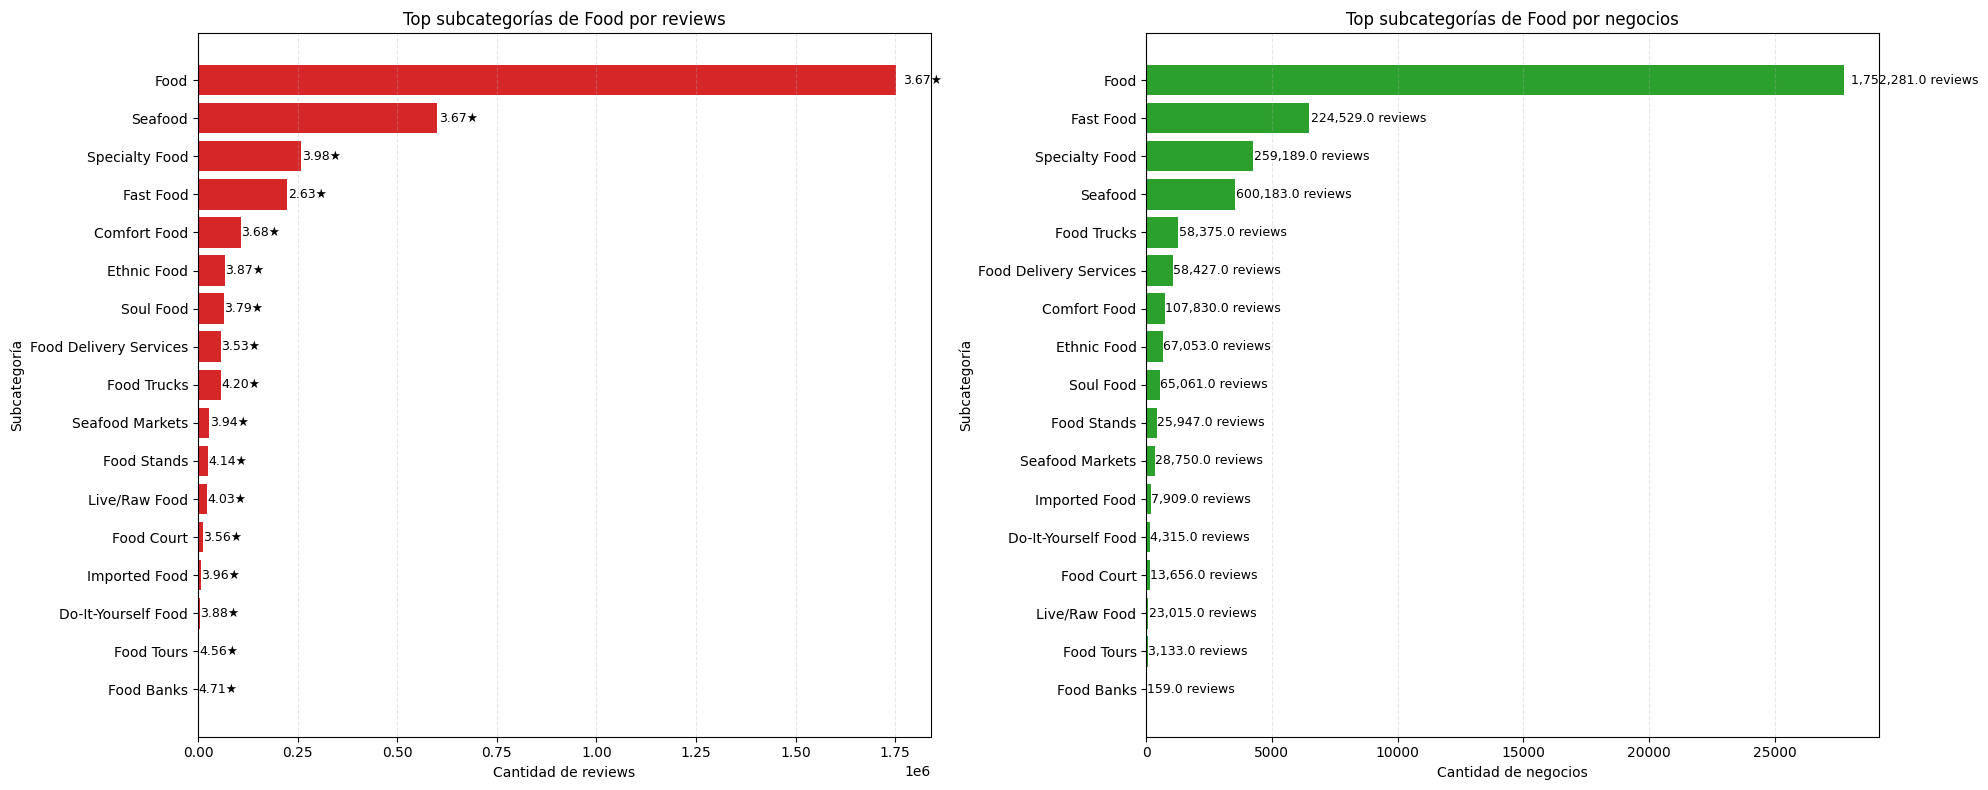

In [247]:
# Subcategorías dentro de Food
food_series = df_business['categories'].fillna('')
food_mask = food_series.str.contains('Food', case=False)
food_df = df_business.loc[food_mask, ['categories', 'stars', 'review_count']].copy()
food_df = food_df[food_df['categories'].notna()]
food_long = (
    food_df.assign(category=food_df['categories'].str.split(','))
    .explode('category')
)
food_long['category'] = food_long['category'].str.strip()
food_long = food_long[food_long['category'].str.contains('Food', case=False, na=False)]

food_stats = (
    food_long.groupby('category')
    .agg(
        num_businesses=('category', 'size'),
        total_reviews=('review_count', 'sum'),
        avg_stars=('stars', 'mean')
    )
    .sort_values('total_reviews', ascending=False)
)
top_food_subcats = food_stats.head(20)
display(top_food_subcats)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
review_order = top_food_subcats.sort_values('total_reviews')
axes[0].barh(review_order.index, review_order['total_reviews'], color='#d62728')
axes[0].set_title('Top subcategorías de Food por reviews')
axes[0].set_xlabel('Cantidad de reviews')
for idx, (cat, row) in enumerate(review_order.iterrows()):
    axes[0].text(row['total_reviews'] * 1.01, idx, f"{row['avg_stars']:.2f}★", va='center', fontsize=9)

count_order = top_food_subcats.sort_values('num_businesses')
axes[1].barh(count_order.index, count_order['num_businesses'], color='#2ca02c')
axes[1].set_title('Top subcategorías de Food por negocios')
axes[1].set_xlabel('Cantidad de negocios')
for idx, (cat, row) in enumerate(count_order.iterrows()):
    axes[1].text(row['num_businesses'] * 1.01, idx, f"{row['total_reviews']:,} reviews", va='center', fontsize=9)

for ax in axes:
    ax.set_ylabel('Subcategoría')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [248]:
# Mapa interactivo para explorar negocios
map_columns = ['name', 'city', 'state', 'postal_code', 'latitude', 'longitude']
map_df = df_business[map_columns].dropna()

# Limitamos la cantidad de puntos para mantener el mapa interactivo ligero
sample_size = 2000 if len(map_df) > 2000 else len(map_df)
map_sample = map_df.sample(sample_size, random_state=42)

center = [map_sample['latitude'].mean(), map_sample['longitude'].mean()]
biz_map = folium.Map(location=center, zoom_start=4, tiles='CartoDB positron')
cluster = MarkerCluster().add_to(biz_map)

for _, row in map_sample.iterrows():
    popup = (
        f"<b>{row['name']}</b><br>"
        f"{row['city']}, {row['state']} {row['postal_code']}"
    )
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        weight=0,
        fill=True,
        fill_color='#1f77b4',
        fill_opacity=0.6,
        popup=''.join(popup),
    ).add_to(cluster)

biz_map
